In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from adv_attack_student import AdversialAttacker
from adv_attack_student import generate_experiment
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import yaml
import numpy as np

In [245]:
class RunExperiments(object):
    def __init__(self, classnames):
        self.classnames = classnames
        self.t1_m1 = {_class: 0 for _class in self.classnames.values()}
        self.t1_m2 = {_class: 0 for _class in self.classnames.values()}
        self.t2_m1 = {_class: 0 for _class in self.classnames.values()}
        self.t2_m2 = {_class: 0 for _class in self.classnames.values()}
        self.t1_viz = {_class: [] for _class in self.classnames.values()}
        self.t2_viz = {_class: [-1]*10 for _class in self.classnames.values()}
    
    def diff_img(self, img1, img2, scale=1):
        return Image.fromarray(
            scale * np.abs(
                np.array(img1).astype('float') - np.array(img2).astype('float')
            ).astype(np.uint8)
        )     
    
    # Untargetted setting
    def t1(self, img, method, class_ind, eps, alpha=0.175, num_steps=4):
        x = generate_experiment(method=method, img_name=img)
        out_pred, scores = x['attacker'].get_pred_label(x['mdl'], x['inp'], ret_out_scores=True, ret_out_pred=True)
        inp_adv = x['attacker'].perturb_untargeted(x['mdl'], x['inp'], targ_label=out_pred, eps=eps, num_steps=num_steps, alpha=alpha)
        attacked_pred, attacked_score = x['attacker'].get_pred_label(x['mdl'], inp_adv, ret_out_scores=True, ret_out_pred=True)
        if int(attacked_pred) != int(out_pred):
            if len(self.t1_viz[self.classnames[class_ind]]) == 0 and method == 'FGSM':
                img_adv = x['un_norm'](inp_adv.squeeze(0))
                img_orig = x['un_norm'](x['inp'].squeeze(0))
                img_prtb = self.diff_img(img_adv, img_orig, scale=20)
                self.t1_viz[self.classnames[class_ind]] += [x['img'], img_adv, img_prtb, attacked_pred]
            return 1
        else:
            return 0
    
    # Targetted setting
    def t2(self, img, method, classes, class_ind, eps, alpha=0.175, num_steps=4):
        score = 0
        viz = [-1]*10
        x = generate_experiment(method=method, img_name=img)
        viz[class_ind] = x['img']
        for _class in classes:
            target_label = torch.tensor([_class])
            inp_adv = x['attacker'].perturb_targeted(x['mdl'], x['inp'], targ_label=target_label, eps=eps, num_steps=num_steps, alpha=alpha)
            attacked_pred, attacked_score = x['attacker'].get_pred_label(x['mdl'], inp_adv, ret_out_scores=True, ret_out_pred=True)
            if int(attacked_pred) == _class:
                viz[_class] = x['un_norm'](inp_adv.squeeze(0))
                score += 1
        if viz.count(-1) < self.t2_viz[self.classnames[class_ind]].count(-1) and method == 'I-FGSM':
            self.t2_viz[self.classnames[class_ind]] = viz
        return score
            
        
    def get_t1_results(self, eps, alpha, num_steps):
        for i in range(10):
            data_path = glob(f'CINIC-10/test/{self.classnames[i]}/*')
            for j, img in enumerate(data_path):
                if j == 100:
                    break
                self.t1_m1[self.classnames[i]] += self.t1(img, method='FGSM', class_ind=i, eps=eps)
                self.t1_m2[self.classnames[i]] += self.t1(img, method='I-FGSM', class_ind=i, eps=eps, alpha=alpha, num_steps=num_steps)
            #print(f'done class: {i}')
    
    def get_t2_results(self, eps, alpha, num_steps):
        for i in range(10):
            classes = set(self.classnames.keys()) - set([i])
            data_path = glob(f'CINIC-10/test/{self.classnames[i]}/*')
            for j, img in enumerate(data_path):
                if j == 10:
                    break
                self.t2_m1[self.classnames[i]] += self.t2(img, method='FGSM', classes=classes, class_ind=i, eps=eps)
                self.t2_m2[self.classnames[i]] += self.t2(img, method='I-FGSM', classes=classes, class_ind=i, eps=eps, alpha=alpha, num_steps=num_steps)
            #print(f'done class: {i}')

In [216]:
with open('./cinic_classnames.yml', 'r') as fp:
    classnames = yaml.safe_load(fp)

In [236]:
grid_search = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1, 10, 100]

In [237]:
t1_m1 = []
t1_m2 = []
t2_m1 = []
t2_m2 = []
for eps in grid_search:
    experiments = RunExperiments(classnames)
    experiments.get_t1_results(eps=eps, alpha=float(eps)/5, num_steps=5)
    experiments.get_t2_results(eps=eps, alpha=float(eps)/5, num_steps=5)
    t1_m1.append((eps, np.mean(list(experiments.t1_m1.values()))))
    t1_m2.append((eps, np.mean(list(experiments.t1_m2.values()))))
    t2_m1.append((eps, np.mean(list(experiments.t2_m1.values()))))
    t2_m2.append((eps, np.mean(list(experiments.t2_m2.values()))))
    print(f'done {eps}')

done 0.0001
done 0.0005
done 0.001
done 0.005
done 0.01
done 0.05
done 0.1
done 0.3
done 0.5
done 1
done 10
done 100


## Repeating experiments for best case epsilon = 1, alpha = 0.2, num_steps = 5

In [246]:
experiments = RunExperiments(classnames)
experiments.get_t1_results(eps=1.0, alpha=0.2, num_steps=5)
experiments.get_t2_results(eps=1.0, alpha=0.2, num_steps=5)

In [255]:
t2_images = []
for val in list(experiments.t2_viz.values()):
    t2_images += val

### Visualizing results

### Targetted setting

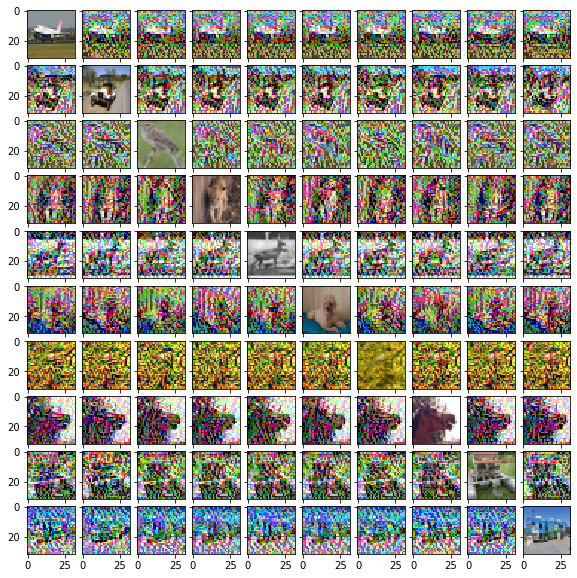

In [256]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, t2_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

### Untargetted setting

In [275]:
t1_images = []
for val in list(experiments.t1_viz.values()):
    t1_images += val

In [276]:
t1_images = list(filter(lambda x: type(x) != torch.Tensor, t1_images))

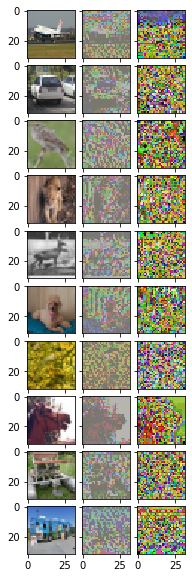

In [277]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, t1_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

### Parameter setting

In [291]:
np.set_printoptions(suppress=True)

In [316]:
t1_m1 = np.array(list(map(lambda x: (x[0], x[1]/100.0), t1_m1)))
t1_m2 = np.array(list(map(lambda x: (x[0], x[1]/100.0), t1_m2)))
t2_m1 = np.array(list(map(lambda x: (x[0], x[1]/90.0), t2_m1)))
t2_m2 = np.array(list(map(lambda x: (x[0], x[1]/90.0), t2_m2)))

In [324]:
grid_search = [str(val) for val in grid_search]

#### T1-M1

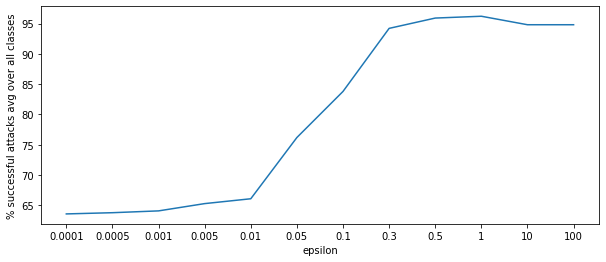

In [336]:
plt.figure(figsize=(10., 4.))
plt.plot(grid_search, t1_m1[:,1]*100)
plt.xlabel('epsilon')
plt.ylabel('% successful attacks avg over all classes')
plt.show()

#### T1-M2

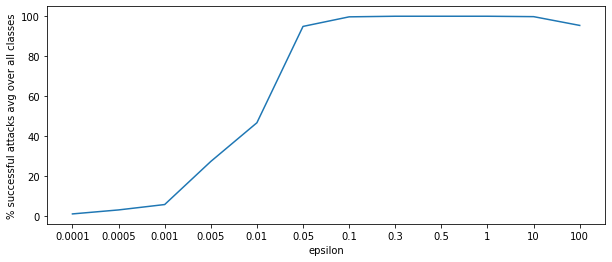

In [338]:
plt.figure(figsize=(10., 4.))
plt.plot(grid_search, t1_m2[:,1]*100)
plt.xlabel('epsilon')
plt.ylabel('% successful attacks avg over all classes')
plt.show()

#### T2-M1

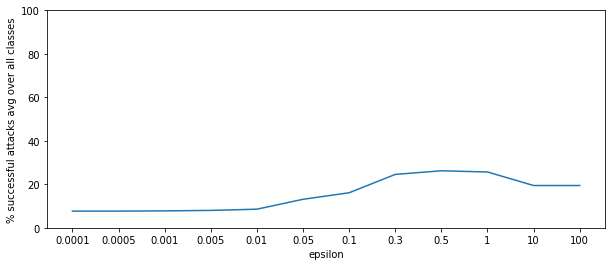

In [341]:
plt.figure(figsize=(10., 4.))
plt.plot(grid_search, t2_m1[:,1]*100)
plt.xlabel('epsilon')
plt.ylabel('% successful attacks avg over all classes')
plt.ylim((0, 100))
plt.show()

#### T2-M2

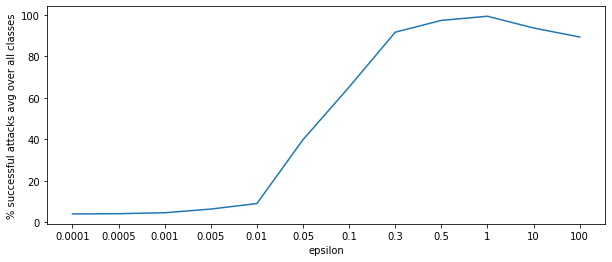

In [340]:
plt.figure(figsize=(10., 4.))
plt.plot(grid_search, t2_m2[:,1]*100)
plt.xlabel('epsilon')
plt.ylabel('% successful attacks avg over all classes')
plt.show()

### Class by class accuracies

<BarContainer object of 10 artists>

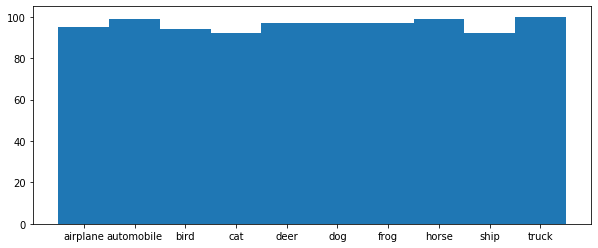

In [354]:
plt.figure(figsize=(10., 4.))
plt.bar(experiments.t1_m1.keys(),experiments.t1_m1.values(), 1)

<BarContainer object of 10 artists>

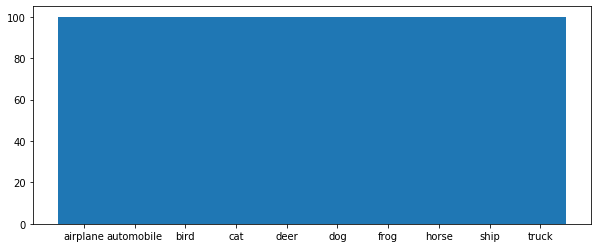

In [355]:
plt.figure(figsize=(10., 4.))
plt.bar(experiments.t1_m2.keys(),experiments.t1_m2.values(), 1)

<BarContainer object of 10 artists>

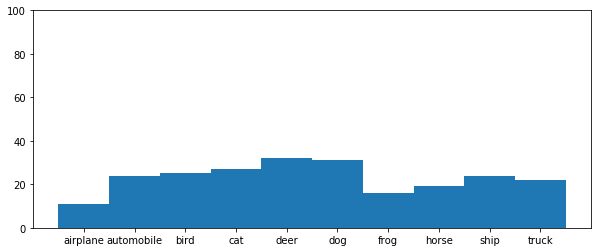

In [358]:
plt.figure(figsize=(10., 4.))
plt.ylim((0, 100))
plt.bar(experiments.t2_m1.keys(),experiments.t2_m1.values(), 1)

<BarContainer object of 10 artists>

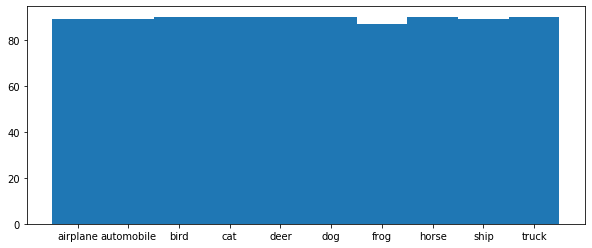

In [357]:
plt.figure(figsize=(10., 4.))
plt.bar(experiments.t2_m2.keys(),experiments.t2_m2.values(), 1)